In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,make_scorer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

from scipy.optimize import minimize
from scipy.stats import linregress

from lightgbm import LGBMRegressor
import lightgbm

from sklearn.ensemble import RandomForestRegressor


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow as tf
import keras.backend as K

%matplotlib inline

In [4]:
# plt.style.use('ggplot')
plt.style.use('seaborn')

In [5]:
f = r'C:\Users\mattk\code\Mkt_Data\all_futures.csv'
df = pd.read_csv(f,index_col=0,parse_dates=[0])
df = df.resample('1B').last()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13112 entries, 1970-03-30 to 2020-06-30
Freq: B
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   AEX      2790 non-null   float64
 1   AUD      8423 non-null   float64
 2   BOBL     3191 non-null   float64
 3   BTP      2680 non-null   float64
 4   BUND     3513 non-null   float64
 5   CAC      2877 non-null   float64
 6   COPPER   6331 non-null   float64
 7   CORN     12248 non-null  float64
 8   CRUDE_W  7868 non-null   float64
 9   EDOLLAR  9262 non-null   float64
 10  EUR      5328 non-null   float64
 11  EUROSTX  1566 non-null   float64
 12  GAS_US   7560 non-null   float64
 13  GBP      11327 non-null  float64
 14  GOLD     11411 non-null  float64
 15  JPY      10932 non-null  float64
 16  KOSPI    1532 non-null   float64
 17  KR10     1520 non-null   float64
 18  KR3      1515 non-null   float64
 19  LEANHOG  11856 non-null  float64
 20  LIVECOW  12537 non-null  

In [6]:
assets = ['AUD', 'COPPER', 'CORN', 'CRUDE_W',
       'EDOLLAR', 'EUR', 'GAS_US', 'GBP', 'GOLD', 'JPY',
       'LEANHOG', 'LIVECOW', 'MXP', 'NASDAQ',
       'PALLAD', 'PLAT', 'SOYBEAN', 'SP500', 'US10', 'US2',
       'US20', 'US5', 'WHEAT']

In [7]:
df2 = df[assets].loc['1/1/2000':'1/1/2020']

In [8]:
# save actual scaled returns to pkl file to be recalled later

# tgt_vol = .15/np.sqrt(252)
# ALL = df2.fillna(method='ffill')
# ALL = ALL.diff().dropna()
# ALL = ((ALL*tgt_vol/ALL.ewm(span=25).std()).shift(-1)).dropna()
# ALL.to_pickle("../results/actual_returns")

In [9]:
all_returns = pd.read_pickle("../results/actual_returns")

In [10]:
all_returns.head()

,AUD,COPPER,CORN,CRUDE_W,EDOLLAR,EUR,GAS_US,GBP,GOLD,JPY,...,NASDAQ,PALLAD,PLAT,SOYBEAN,SP500,US10,US2,US20,US5,WHEAT
DATETIME,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.007216,-0.003898,0.026726,-0.003742,0.004112,-0.007223,0.012335,0.093541,0.002110,-0.467707,...,-0.017243,-0.037417,-0.027069,-0.001432,-0.011136,0.004351,0.004626,0.005797,0.004261,-0.001485
2000-01-06,0.001522,0.001595,0.021714,0.003767,0.007082,-0.007991,-0.005525,-0.010152,0.004152,0.002322,...,0.010023,0.011592,0.002629,0.010721,0.014747,0.006065,0.005784,0.005671,0.006469,0.011317
2000-01-07,0.004155,-0.010467,0.017090,0.011946,-0.006691,-0.013731,0.011668,-0.002512,-0.002076,0.001361,...,0.009421,0.011358,0.003326,-0.008755,0.004518,-0.004680,-0.009373,-0.004685,-0.007257,0.013883
2000-01-10,0.008997,-0.004858,-0.003713,0.013294,-0.013896,0.015428,0.014104,0.013296,0.013517,-0.011089,...,-0.008421,-0.003853,-0.000766,0.005107,-0.006485,0.000000,-0.012719,0.000000,-0.013119,0.000000
2000-01-11,0.000000,0.018222,0.023310,0.008006,-0.004829,-0.003479,-0.002708,0.000000,-0.005909,-0.000333,...,-0.003473,0.004896,0.006681,0.013109,-0.004021,-0.016538,-0.006111,-0.014400,-0.006204,0.020979


In [11]:
def calc_macd(ser,s=8,l=24):
    '''
    input = series
    
    '''
    x = ser.ewm(span=(2*s-1)).mean() - ser.ewm(span=(2*l-1)).mean()
    y = x/ser.diff().ewm(span=25).std()
    y = y/y.rolling(252).std()
    return y

def momentum(closes):
    x = np.arange(len(closes))
    slope, _, rvalue, _, _ = linregress(x, closes)
    return (((1 + slope) ** 252)-1) * (rvalue ** 2)

def get_feat_ret(asset,df):
    df3 = df.copy(deep=True)
    df3 = df3[[asset]]
    df3.fillna(method = 'ffill',inplace=True)
    df3['dif'] = df3[asset].diff()
    df3.dropna(inplace=True)
    
    tgt_vol = .15/np.sqrt(252)
    
    df3['macd1'] = calc_macd(df3[asset])
    df3['macd2'] = calc_macd(df3[asset],16,48)
    df3['macd3'] = calc_macd(df3[asset],32,96)
    df3['trend1'] = (df3[asset] - df3[asset].shift(1))/(df3[asset].diff().ewm(span=25).std()) # 1d
    df3['trend2'] = (df3[asset] - df3[asset].shift(21))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(21)) # 1m
    df3['trend3'] = (df3[asset] - df3[asset].shift(63))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(63)) # 3m
    df3['trend4'] = (df3[asset] - df3[asset].shift(126))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(126)) # 6m
#     df3['trend5'] = (df3[asset] - df3[asset].shift(252))/(df3[asset].diff().ewm(span=25).std()*np.sqrt(252)) # 1y
    
    #extra features
    df3['mom'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).rolling(60).apply(momentum)

    # df3['scaled_return_next'] = (df3[asset].diff()).shift(-1) # no vol scaling
    df3['scaled_return_next'] = (df3['dif']*tgt_vol/df3['dif'].ewm(span=25).std()).shift(-1)

    df3.dropna(inplace=True)
    
    feat = df3[['macd1','macd2','macd3','trend1','trend2','trend3','trend4','mom']]
    feat = feat.add_prefix(str(asset)+'_')
    ret = df3[['scaled_return_next']]
    
    return feat,ret

In [12]:
# Define rules that generates a forecast from X dataframe

### allow for sliding window features
def data_transform(x_data, y_data, num_steps=10):
    """ Changes data to the format for LSTM training 
    for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array


### direct positions (benchmarks only) ###
def Bench_LS(ydata):
    assert isinstance(ydata,pd.DataFrame) or isinstance(ydata,pd.Series), 'xdata needs to be pandas DataFrame or Series'
    
    out = pd.DataFrame(np.ones(shape=ydata.shape[0]),index=ydata.index,columns=ydata.name)
    
    return out

def Bench_MACD(xdata):
    assert isinstance(xdata,pd.DataFrame) or isinstance(xdata,pd.Series), 'xdata needs to be pandas DataFrame or Series'
    msk = xdata.loc[:,xdata.columns.str.contains('macd')]
    
    out = pd.DataFrame(np.where(msk.mean(axis=1)>0,1.0,-1.0),index=xdata.index)
    
    return out

def Bench_Trend(xdata):
    assert isinstance(xdata,pd.DataFrame) or isinstance(xdata,pd.Series), 'xdata needs to be pandas DataFrame or Series'
    msk = xdata.loc[:,xdata.columns.str.contains('trend')]
    
    out = pd.DataFrame(np.where(msk.mean(axis=1)>0,1.0,-1.0),index=xdata.index)
    
    return out

### Custom Loss ###

def CustomLoss(yTrue,yPred):
    ix = np.logical_and((yPred*yTrue)>0,np.abs(yTrue)>=np.abs(yPred))
    n = ((yPred - yTrue)**2)*2
    y = (yPred-yTrue)**2
    out = np.where(ix,y,n)
    return np.mean(out)

def obj_function(beta, X, Y):
    pen = 2
    yPred = X.dot(beta)
    ix = np.logical_and((yPred*Y)>0,np.abs(Y)>=np.abs(yPred))
#     resid = (yPred-Y)**2
    resid = np.sqrt((yPred-Y)**2)
    no = resid*pen
    yes = resid
    
    out = np.where(ix,yes,no)
    
    return np.mean(out)
    
def custom_asymmetric_eval(y_true, y_pred):
    penalty = 2.0
    residual = (y_pred - y_true).astype("float")
    ix = np.logical_and((y_pred*y_true)>0,np.abs(y_true)>=np.abs(y_pred))
    loss = np.where(ix, (residual**2), (residual**2)*penalty)
    return "custom_asymmetric_eval", np.mean(loss), False

def custom_asymmetric_objective(y_true, y_pred):
    penalty = 2.0
    resid = (y_pred - y_true).astype("float")
    ix = np.logical_and((y_pred*y_true)>0,np.abs(y_true)>=np.abs(y_pred))
    grad = np.where(ix, 2.0*resid, 2*penalty*resid)
    hess = np.where(ix, 2.0, 2.0*penalty)
    return grad, hess

def sortinoLoss(yTrue,yPred):
    u = K.mean(yPred*yTrue,axis=1)
    n = -K.mean(u)*np.sqrt(252)
    
    d = K.std(K.minimum(u,0.0))
    
    return tf.math.divide_no_nan(n,d)

def k_asymm(yTrue,yPred):
    pen = 6.0
    ix = tf.logical_and((yPred*yTrue)>0,K.abs(yTrue)>=K.abs(yPred))
#     ix = (yPred*yTrue)>0
    y = K.square(yTrue-yPred)
    n = K.square(yTrue-yPred)*pen
    out = tf.where(ix,y,n)
    out = tf.cast(out, tf.float32)
    
    return K.sum(out)/tf.cast(len(yTrue), tf.float32)

### Forecasts ### 

def OLS_Forecast(xtrain,ytrain,xtest,ytest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    lm = LinearRegression()
    lm.fit(xtrain,ytrain)
    preds = lm.predict(xtest)
    
    out = pd.DataFrame(preds,index=xtest.index,columns=[ytrain.columns])
    
    return out

    
def LightGBM(xtrain,ytrain,xtest,ytest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
#     train_size = int(len(xtrain)*.85)
#     val_size = len(xtrain)-train_size

    #change y's if multiple outputs
#     xtrain2,xval = xtrain.iloc[0:train_size,:], xtrain.iloc[train_size:len(xtrain),:]
#     ytrain2,yval = ytrain.iloc[0:train_size], ytrain.iloc[train_size:len(xdata)]
    
    tss = TimeSeriesSplit(n_splits=5)


    gbm = LGBMRegressor()

    param_grid = {
        "num_leaves": [15,30,50,100],
        "max_depth": [1,2,6,10,15,25],
        "learning_rate" : [0.1,.001,.0001],
        "n_estimators" : [25,50,100,150],
    #     "reg_alpha" : [1,.1,.01,.0001],
    #     "reg_lambda" : [1,.1,.01,.0001],
        }


    rs = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_grid, 
        cv=tss.split(xtrain),
        n_iter=25,
        n_jobs=-1, 
        scoring='neg_mean_squared_error',
        verbose=0,
        error_score = 'raise'
        )
    rs.fit(xtrain,ytrain)
    preds = rs.predict(xtest)
    print(rs.best_params_)
    
    out = pd.DataFrame({'forecast':preds},index=xtest.index) 
    
    return out

def LightGBM_Custom(xtrain,ytrain,xtest,ytest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    rs_scorer = make_scorer(CustomLoss,greater_is_better=False)

    tss = TimeSeriesSplit(n_splits=5)


    gbm = LGBMRegressor()
    # gbm.set_params(**{'objective': custom_asymmetric_objective})


    param_grid = {
        "objective": [custom_asymmetric_objective],
        "num_leaves": [15,30,50,100],
        "max_depth": [-1,2,6,10,15,25],
        "learning_rate" : [0.1,.001,.0001],
        "n_estimators" : [25,50,100,150],
    #     "reg_alpha" : [1,.1,.01,.0001],
    #     "reg_lambda" : [1,.1,.01,.0001],
        }


    rs = RandomizedSearchCV(
        estimator=gbm,
        param_distributions=param_grid, 
        cv=tss.split(xtrain),
        n_iter=25,
        n_jobs=-1, 
        scoring = rs_scorer,
        verbose=0,
        error_score = 'raise'
        )
    
    
    rs.fit(xtrain,ytrain.squeeze())
#     model.save_model(filepath, num_iteration=model.best_iteration) 
    preds = rs.predict(xtest)
    print(rs.best_params_)
    
    out = pd.DataFrame({'forecast':preds},index=xtest.index) 
    
    return out

def LSTM_Forecast(xtrain,ytrain,xtest,ytest,verbose=0,plot=False, save = True):
    
    num_steps = 50
    
    # train fewer so that testing size matches rest
    i = len(xtrain)

    fullx  = pd.concat((xtrain,xtest))
    fully  = pd.concat((ytrain,ytest))
    xtrain2 = fullx.iloc[:i-num_steps,:]
    xtest2 = fullx.iloc[i-num_steps:,:]
    ytrain2 = fully.iloc[:i-num_steps,:]
    ytest2 = fully.iloc[i-num_steps:,:]

    t_xtrain, t_ytrain = data_transform(xtrain2.to_numpy(),ytrain2.to_numpy(),num_steps = num_steps)
    t_xtest, t_ytest = data_transform(xtest2.to_numpy(),ytest2.to_numpy(), num_steps = num_steps)
    
    if save:
        callbacks=[
                  tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)]
    else:
        callbacks=[]
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(t_xtrain.shape[1], t_xtrain.shape[2])),
        tf.keras.layers.LSTM(20,dropout=.3,recurrent_dropout=.3),
        tf.keras.layers.Dense(t_ytrain.shape[1])
    ])
    model.compile(loss='mse', optimizer=tf.optimizers.Adam(learning_rate=.001))
    
    history = model.fit(t_xtrain, t_ytrain, epochs=100 ,verbose=verbose,
                        validation_split=.25, shuffle=True,
                        callbacks=callbacks,
                        batch_size=int(len(t_xtrain)/5))
    
    if plot:
        plt.plot(history.history['loss'],label = 'train')
        plt.plot(history.history['val_loss'],label='val')
        plt.legend()
    
#     joblib.dump(model, filepath)

    m2 = tf.keras.models.load_model(filepath)
    pred = m2.predict(t_xtest)
#     pred  = model.predict(t_xtest)
    
    return pd.DataFrame(pred,index=xtest.index)

def LSTM_Forecast_Asymm(xtrain,ytrain,xtest,ytest,verbose=0,plot=True, save = True):
    
    num_steps = 50
    
    # train fewer so that testing size matches rest
    i = len(xtrain)

    fullx  = pd.concat((xtrain,xtest))
    fully  = pd.concat((ytrain,ytest))
    xtrain2 = fullx.iloc[:i-num_steps,:]
    xtest2 = fullx.iloc[i-num_steps:,:]
    ytrain2 = fully.iloc[:i-num_steps,:]
    ytest2 = fully.iloc[i-num_steps:,:]

    t_xtrain, t_ytrain = data_transform(xtrain2.to_numpy(),ytrain2.to_numpy(),num_steps = num_steps)
    t_xtest, t_ytest = data_transform(xtest2.to_numpy(),ytest2.to_numpy(), num_steps = num_steps)
    
    if save:
        callbacks=[
                  tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)]
    else:
        callbacks=[]
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(t_xtrain.shape[1], t_xtrain.shape[2])),
        tf.keras.layers.LSTM(6,dropout=.7,
                             recurrent_dropout=.7
                            ),
        tf.keras.layers.Dense(t_ytrain.shape[1])
    ])
    model.compile(loss=k_asymm, optimizer=tf.optimizers.Adam())
    
    history = model.fit(t_xtrain, t_ytrain, epochs=50 ,verbose=verbose,
                        validation_split=.25, shuffle=True,
                        callbacks=callbacks,
                        batch_size=int(len(t_xtrain)/6))
    
    if plot:
        plt.plot(history.history['loss'],label = 'train')
        plt.plot(history.history['val_loss'],label='val')
        plt.legend()
        plt.show()
    
#     joblib.dump(model, filepath)

    m2 = tf.keras.models.load_model(filepath,compile=False)
    m2.compile(loss=k_asymm, optimizer=tf.optimizers.Adam(learning_rate=.001))
    pred = m2.predict(t_xtest)
#     pred  = model.predict(t_xtest)
    
    return pd.DataFrame(pred,index=xtest.index)

### Functions to predict actual positions

def RF_Forecast(xtrain,ytrain,xtest,ytest):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    rf = RandomForestRegressor()
    
    rf.fit(xtrain,ytrain)
    out = rf.predict(xtest)
    
    return pd.DataFrame(out,index=xtest.index,columns=ytrain.columns)

def Linear_Custom(xtrain,ytrain,xtest,ytest,verbose=0, plot=False, loss = sortinoLoss, thresh = -22.0, save = False ):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    if save:
        callbacks=[
                  tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)]
    else:
        callbacks=[]
        
    
    
    lrc_model = tf.keras.Sequential([
        tf.keras.layers.Dense(ytrain.shape[1],use_bias=True,input_shape = (xtrain.shape[1],),activation='tanh')
    ])
    
    lrc_model.compile(optimizer='adam',loss=loss)
    
    
    history = lrc_model.fit(xtrain_sc, ytrain, epochs=500,verbose=verbose,
                            validation_split=.25, shuffle=True,
                            callbacks=callbacks,
                            batch_size=int(len(xtrain_sc)/5)
                           )
    if plot:
        plt.plot(history.history['loss'],label='train')
#         plt.plot(history.history['val_loss'],label='val')
    
    out = lrc_model.predict(xtest)

    return pd.DataFrame(out,index=xtest.index,columns=ytrain.columns)

def LSTM_Position(xtrain,ytrain,xtest,ytest,verbose=2,plot=False,loss=sortinoLoss,thresh=-22.0,save=True):
    
    num_steps = 50
    
    # train fewer so that testing size matches rest
    i = len(xtrain)

    fullx  = pd.concat((xtrain,xtest))
    fully  = pd.concat((ytrain,ytest))
    xtrain2 = fullx.iloc[:i-num_steps,:]
    xtest2 = fullx.iloc[i-num_steps:,:]
    ytrain2 = fully.iloc[:i-num_steps,:]
    ytest2 = fully.iloc[i-num_steps:,:]

    t_xtrain, t_ytrain = data_transform(xtrain2.to_numpy(),ytrain2.to_numpy(),num_steps = num_steps)
    t_xtest, t_ytest = data_transform(xtest2.to_numpy(),ytest2.to_numpy(), num_steps = num_steps)
    
    if save:
        callbacks=[
                  tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)]
    else:
        callbacks=[]
        
        
        
    
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(t_xtrain.shape[1], t_xtrain.shape[2])),
        tf.keras.layers.LSTM(20,dropout=.3,recurrent_dropout=.3),
        tf.keras.layers.Dense(t_ytrain.shape[1],activation='tanh')
    ])
    model.compile(loss=loss, optimizer=tf.optimizers.Adam())
    
    history = model.fit(t_xtrain, t_ytrain, epochs=100,verbose=verbose,
                        validation_split=.25, shuffle=False,
                        callbacks=callbacks,
                        batch_size=int(len(t_xtrain)/5),
                       )
    
    if plot:
        plt.plot(history.history['loss'],label='train')
        plt.plot(history.history['val_loss'],label='val')
        plt.legend()
        
    m2 = tf.keras.models.load_model(filepath,compile=False)
    m2.compile(loss=loss, optimizer=tf.optimizers.Adam(learning_rate=.001))
    pred = m2.predict(t_xtest)
    
    
    return pd.DataFrame(pred,index=xtest.index,columns=ytest.columns)


### Functions to get positions and stats

def set_position(d,how=1,Tstd = .15):
    '''
    Given an array of forecasts, return position in assets
    
    params:
    ...........
    how:
        1 = binary -1 or 1 based on sign of the forecast
        2 = +1/-1 if forecaste > 1 std of target, 0 otherwise
    '''
    f = d.copy()
    
    if how==1:
        return np.sign(f)
    
    if how==2:
        
        f[(f>-Tstd/np.sqrt(252)) & (f<Tstd/np.sqrt(252))] = 0.0
        f[f>=Tstd/np.sqrt(252)] = 1.0
        f[f<=-Tstd/np.sqrt(252)] = -1.0
        
        return f
    if how==3:
        f = f/(np.abs(f).mean())
        f = f.clip(-2,2)
        return f
    
    # Long top x, short bottom x
    if how == 4:
        ar = f.values

        n_smallest = 3
        n_biggest = 3

        assert n_smallest + n_biggest <= ar.shape[1], 'small/big bigger than dataset'
        assert np.logical_and(n_smallest>0,n_biggest>0), 'n chosen must be >0'

        msk_small = np.partition(ar, 0+n_smallest-1,axis=1)[:,n_smallest-1].reshape(-1,1) # smallest
        msk_big = np.partition(ar, -1*n_biggest,axis=1)[:,-1*n_biggest].reshape(-1,1) #biggest

        out = pd.DataFrame((ar>=msk_big).astype('int') - (ar<=msk_small).astype('int'),index=f.index,columns=f.columns)
        
        return out
    
def get_returns(p,r,how=1):
    assert p.shape == r.shape, 'Data not the same shape!'
    
    rets = p*r
    if how ==1:
        return rets.mean(axis=1)
    else:
        return rets
    
def stats(r,factor=252,verbose = False):
    u = r.mean()*factor
    sig = r.std()*np.sqrt(factor)
    
    
    if verbose:
        print('Return: {}'.format(u))
        print('Vol: {}'.format(sig))
        print('Sharpe: {}'.format(u/sig))
    
    return u, sig, u/sig

In [13]:
# Example of features dataframe

ex1,ex2 = get_feat_ret('GOLD',df2)
ex1.tail()

,GOLD_macd1,GOLD_macd2,GOLD_macd3,GOLD_trend1,GOLD_trend2,GOLD_trend3,GOLD_trend4,GOLD_mom
DATETIME,,,,,,,,
2019-12-25,-0.063042,0.179085,2.486612,1.403849,1.186715,-0.135656,0.636252,0.000169
2019-12-26,0.100254,0.275145,2.608330,0.481497,1.257766,0.000000,0.831410,0.000614
2019-12-27,0.303320,0.389698,2.634037,1.353509,1.692166,0.733618,0.872950,0.001503
2019-12-30,0.487869,0.511047,2.757698,-0.043737,1.549327,0.466538,1.257227,0.001376
2019-12-31,0.698196,0.643242,2.791222,1.421524,1.908692,0.277780,1.396910,0.001549


In [ ]:
#Generate Predictions - FORECASTING MODELS

times = [('2000','2003','2004','2007'),
      ('2000','2007','2008','2011'),
      ('2000','2011','2012','2015'),
      ('2000','2015','2016','2019')
     ]

# times = [('2000','2003','2004','2007'),
#       ('2004','2007','2008','2011'),
#       ('2008','2011','2012','2015'),
#       ('2012','2015','2016','2019')
#      ]


port=[]


models=[
#     OLS_Forecast,
    LSTM_Forecast_Asymm,
#     LSTM_Forecast,
#     LightGBM_Custom,
       ]

for m in models:
    group=[]
    print(str(m))

    for asset in assets:
        print(asset)
        pfull = []
        
        d = get_feat_ret(asset,df2)
        xdata = d[0].copy()
        ydata = d[1].copy()
        
        for ts1,ts2,tr1,tr2 in times:
            print('--------------')
            print(ts1,ts2,tr1,tr2)
            print('--------------')
            
            xtrain,xtest = xdata[ts1:ts2], xdata[tr1:tr2]
            ytrain,ytest = ydata[ts1:ts2], ydata[tr1:tr2]
            

            scalerX = StandardScaler()

#             xtrain_sc = pd.DataFrame(scalerX.fit_transform(xtrain.to_numpy()),columns=xtrain.columns,index=xtrain.index)
#             xtest_sc = pd.DataFrame(scalerX.transform(xtest.to_numpy()),columns=xtest.columns,index=xtest.index)
            
            ##### Not standard, just normalize
            xtrain_sc = xtrain/xtrain.std()
            xtest_sc = xtest/xtrain.std()
            
            #####
            
            filepath="../results/"+str(m.__name__) + "-" + str(asset) + "-" + str(tr1) + "-" + str(tr2) + "-used.hdf5"
            
            pred = m(xtrain_sc,ytrain,xtest_sc,ytest)
            pred.columns = [asset]
#             pfull.append(np.sign(pred))
            pfull.append(pred)
            
        group.append(pd.concat(pfull))
        
    f = "../results/Test_" + str(m.__name__) + "_forecast"
    pd.concat(group,axis=1).to_pickle(f)
    
    port.append((str(m.__name__),pd.concat(group,axis=1)))
print('done')

In [ ]:
#Generate Predictions - POSITION MODELS

times = [
    ('2000','2003','2004','2007'),
    ('2000','2007','2008','2011'),
    ('2000','2011','2012','2015'),
    ('2000','2015','2016','2019')
     ]

# times = [('2000','2002','2003','2005'),
#          ('2003','2005','2006','2008'),
#          ('2006','2008','2009','2011'),
#          ('2009','2011','2012','2014'),
#          ('2012','2014','2015','2017'),
#          ('2015','2017','2018','2019'),
#      ]


port=[]

xdata = []
ydata = []


models=[
#     OLS_Forecast,
#     LSTM_Forecast,
#     RF_Forecast,
#     Linear_Custom,
    LSTM_Position,
       ]



for a in assets:
    d = get_feat_ret(a,df2)
    xdata.append(d[0])
    ydata.append(d[1])
    
xdata = pd.concat(xdata,axis=1)
xdata.dropna(inplace=True)

ydata = pd.concat(ydata,axis=1)
ydata.columns = assets
ydata.dropna(inplace=True)


for m in models:
    group=[]
    print(str(m))

    for ts1,ts2,tr1,tr2 in times:
        print('--------------')
        print(ts1,ts2,tr1,tr2)
        print('--------------')

        xtrain,xtest = xdata[ts1:ts2], xdata[tr1:tr2]
        ytrain,ytest = ydata[ts1:ts2], ydata[tr1:tr2]
        

        scalerX = StandardScaler()

        xtrain_sc = pd.DataFrame(scalerX.fit_transform(xtrain.to_numpy()),columns=xtrain.columns,index=xtrain.index)
        xtest_sc = pd.DataFrame(scalerX.transform(xtest.to_numpy()),columns=xtest.columns,index=xtest.index)

        ##### Not standard, just normalize
        xtrain_sc = xtrain/xtrain.std()
        xtest_sc = xtest/xtrain.std()

        #####

        filepath="../results/"+str(m.__name__) + "-" + str(asset) + "-" + str(tr1) + "-" + str(tr2) + "-used.hdf5"

        pred = m(xtrain_sc,ytrain,xtest_sc,ytest)
#             pred.columns = [asset]
#             pfull.append(np.sign(pred))
        group.append(pred)
            
        
    f = "../results/Test_" + str(m.__name__) + "_positions"
    out = pd.concat(group)
    out.columns = assets
    
    out.to_pickle(f)
    
    port.append((str(m.__name__),pd.concat(group,axis=1)))
print('done')

In [ ]:
# custom check
# read = "../results/best_predictions/Best_" + "Linear_Custom" + "_positions"
read = "../results/Test_" + "LightGBM_Custom" + "_forecast"
# LightGBM_Custom LSTM_Forecast_Asymm

forecast = pd.read_pickle(read)
# forecast = pd.read_pickle(f)
position = set_position(forecast,how=3)
returns = position.mul(all_returns.loc[position.index,:]).mean(axis=1)
stats(returns,verbose=True)

In [ ]:
# custom check positions
# read = "../results/best_predictions/Best_" + "Linear_Custom" + "_positions"
# read = "../results/Test_" + "RF_Forecast" + "_positions"
read = "../results/Test_" + "LSTM_Position" + "_positions"
position = pd.read_pickle(read)
position.columns = assets
# forecast = pd.read_pickle(f)
# position = set_position(forecast,how=1)
returns = position.mul(all_returns.loc[position.index,:]).mean(axis=1)
stats(returns,verbose=True)

In [16]:
# Convert predictions to positions + Stats

models=[
    OLS_Forecast,
    LSTM_Forecast,
#     LSTM_Forecast_Asymm,
    LightGBM_Custom,
    RF_Forecast,
       ]

p_models = [
    Linear_Custom,
    LSTM_Position
]


all_returns = pd.read_pickle("../results/actual_returns")

combined = []
port_ret = []

for m in models:
    print(m.__name__)
#     read = "../results/Test_" + str(m.__name__) + "_forecast"
    read = "../results/best_predictions/Best_" + str(m.__name__) + "_forecast"

    forecast = pd.read_pickle(read)
    position = set_position(forecast,how=1)
    returns = position.mul(all_returns.loc[position.index,:]).mean(axis=1)
    stats(returns,verbose=True)
    print('--------')
    combined.append(position)
    port_ret.append(returns)
    
for m in p_models:
    print(m.__name__)
#     read = "../results/Test_" + str(m.__name__) + "_positions"
    read = "../results/best_predictions/Best_" + str(m.__name__) + "_positions"

    position = pd.read_pickle(read)
    returns = position.mul(all_returns.loc[position.index,:]).mean(axis=1)
    stats(returns,verbose=True)
    print('--------')
    combined.append(position)
    port_ret.append(returns)
    
    
# print('testLSTMAsymmforecast') 
# read = '../results/Test_LSTM_Forecast_Asymm_forecast'
# # read = '../results/Test_LSTM_Forecast_Asymm_forecast'
# forecast = pd.read_pickle(read)
# position = set_position(forecast,how=1)
# returns = position.mul(all_returns.loc[position.index,:]).mean(axis=1)
# stats(returns,verbose=True)
# print('--------')
# combined.append(position)
# port_ret.append(returns)
    
    
print('*********')
print('Combined Returns')
avg_position = pd.concat(combined).groupby(pd.concat(combined).index).mean()
avg_returns = avg_position.mul(all_returns.loc[avg_position.index,:]).mean(axis=1)
port_returns = pd.concat(port_ret,axis=1)
stats(avg_returns,verbose=True)

OLS_Forecast
Return: 0.037125013607112976
Vol: 0.04059663063811044
Sharpe: 0.9144850945403716
--------
LSTM_Forecast
Return: 0.01595818888019039
Vol: 0.029687468138144234
Sharpe: 0.5375395707687971
--------
LightGBM_Custom
Return: 0.02151306832123616
Vol: 0.033758278530189936
Sharpe: 0.6372679312423197
--------
RF_Forecast
Return: 0.03941306941756824
Vol: 0.04772452511829075
Sharpe: 0.825845187979941
--------
Linear_Custom
Return: 0.012953761188812024
Vol: 0.02343224011663976
Sharpe: 0.5528178750444465
--------
LSTM_Position
Return: 0.009349942748565918
Vol: 0.010368218364143282
Sharpe: 0.9017887567743657
--------
*********
Combined Returns
Return: 0.02271884069391428
Vol: 0.016922399641049014
Sharpe: 1.342530679798196


(0.02271884069391428, 0.016922399641049014, 1.342530679798196)

<AxesSubplot:>

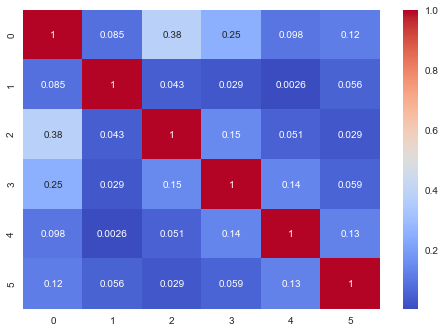

In [17]:
sns.heatmap(port_returns.corr(),annot=True,cmap='coolwarm')

<AxesSubplot:xlabel='DATETIME'>

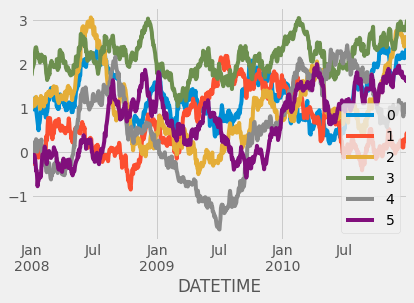

In [64]:
f=(port_returns.rolling(252).mean()*np.sqrt(252)/port_returns.rolling(252).std())
f['2008':'2010'].plot()

In [ ]:
(((port_returns.mean(axis=1)).rolling(252).mean()*np.sqrt(252))/(port_returns.mean(axis=1)).rolling(252).std()).plot()

1. Individual OLS mse forecasts, binary position: 0.9144850945403715
2. Individual lighgbm custom forecasts, binary position: 0.6372679312423225
3. Individual LSTM custom asymmetric forecast, binary position: 0.5375395707687977
---
4. Portfolio mse Random Forest forecast, binary positions: 0.8258451879799403
5. Portfolio Linear Sortino Positions: 0.5528178750444462
6. Portfolio LSTM Sortino Positions: 0.9017887567743633
---
7. Equal Weight Combination
8. Custom Combination

# Benchmarks

In [ ]:
# Long Only
f = all_returns.loc[avg_position.index,:].mean(axis=1)
f.mean()*np.sqrt(252)/f.std()

In [ ]:
b1 = []
b2 = []
b3 = []
for a in assets:
#     print(a)
    d = get_feat_ret(asset,df2)
    x = d[0].copy()
#     ydata = d[1].copy()
#     x = xdata.loc[:,xtest.columns.str.contains(a+'_')]
#     y = ydata.loc[:,a]
    
    b1.append(pd.DataFrame(np.ones(len(x)),index=x.index,columns=[a]))
    b2.append(Bench_MACD(x))
    b3.append(Bench_Trend(x))
    
    
    
b1 = pd.concat(b1,axis=1)
b2 = pd.concat(b2,axis=1)
b2.columns = assets
b3 = pd.concat(b3,axis=1)
b3.columns = assets

In [ ]:
bench_long = b1.loc[avg_position.index,:].mul(all_returns.loc[avg_position.index,:]).mean(axis=1)
bench_macd = b2.loc[avg_position.index,:].mul(all_returns.loc[avg_position.index,:]).mean(axis=1)
bench_trend = b3.loc[avg_position.index,:].mul(all_returns.loc[avg_position.index,:]).mean(axis=1)

In [ ]:
x

In [ ]:
print(stats(bench_long))
print(stats(bench_macd))
print(stats(bench_trend))
print(stats(avg_returns))

In [ ]:
compares = dict( (name,eval(name)) for name in ['avg_returns','bench_long','bench_macd','bench_trend'] )
for i in compares:
    x = compares[i]
    (x.rolling(252).mean()*np.sqrt(252)/x.rolling(252).std()).plot(label=i)
    plt.legend()

# Try Stack of dif weights

In [ ]:
(port_returns).mean(axis=1).hist(bins=50)

In [ ]:
port_returns.info()

In [ ]:
import cvxpy as cp

In [ ]:
times = [
#     ('2000','2003','2004','2007'),
      ('2000','2007','2008','2011'),
      ('2000','2011','2012','2015'),
      ('2000','2015','2016','2019')
     ]

alt_ret = []
alt_ret.append(avg_returns[:'2007'])

for ts1,ts2,tr1,tr2 in times:
    print('--------------')
    print(ts1,ts2,tr1,tr2)
    print('--------------')

    xtrain,xtest = port_returns[ts1:ts2], port_returns[tr1:tr2]

    u = np.mean(xtrain,axis=0)
    cov = np.cov(xtrain.T)
    
#     A = np.asmatrix([[1,0,0],[0,1,0],[0,0,1]])
    A = np.eye(6)
#     bounds = np.asmatrix([0.05, 0.05, 0.05])
    bounds = np.full([1,6],.14)
    A_mod = A - bounds.T


    y = cp.Variable(len(cov))

    f =cp.quad_form(y, cov)
    prob = cp.Problem(cp.Minimize(f), 
                   [y@u == 1, 
                    y >= 0,
                    A_mod@y.T >= 0
                   ])
    prob.solve()

    x = y.value/y.value.sum()
    

    print(x)
    print(x.sum())
    
    alt_ret.append(xtest.dot(x.T))
    

In [ ]:
stats(pd.concat(alt_ret))

In [ ]:
100/6

In [ ]:
def Stacked_Weights(xtrain,ytrain,xtest,ytest,verbose=0, plot=False, loss = sortinoLoss, thresh = -22.0, save = False ):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    


def Linear_Custom(xtrain,ytrain,xtest,ytest,verbose=0, plot=False, loss = sortinoLoss, thresh = -22.0, save = False ):
    assert isinstance(xtrain,pd.DataFrame) or isinstance(xtrain,pd.Series), 'xtrain needs to be pandas DataFrame or Series'
    assert isinstance(ytrain,pd.DataFrame) or isinstance(ytrain,pd.Series), 'ytrain needs to be pandas DataFrame or Series'
    assert isinstance(xtest,pd.DataFrame) or isinstance(xtest,pd.Series), 'xtest needs to be pandas DataFrame or Series'
    
    if save:
        callbacks=[
                  tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True)]
    else:
        callbacks=[]
        
    
    
    lrc_model = tf.keras.Sequential([
        tf.keras.layers.Dense(ytrain.shape[1],use_bias=True,input_shape = (xtrain.shape[1],),activation='tanh')
    ])
    
    lrc_model.compile(optimizer='adam',loss=loss)
    
    
    history = lrc_model.fit(xtrain_sc, ytrain, epochs=500,verbose=verbose,
                            validation_split=.25, shuffle=True,
                            callbacks=callbacks,
                            batch_size=int(len(xtrain_sc)/5)
                           )
    if plot:
        plt.plot(history.history['loss'],label='train')
#         plt.plot(history.history['val_loss'],label='val')
    
    out = lrc_model.predict(xtest)

    return pd.DataFrame(out,index=xtest.index,columns=ytrain.columns)